# **Setup and Data Loading**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [42]:
titanic = sns.load_dataset('titanic')

# Select features & target
df = titanic[['pclass', 'sex', 'age', 'fare', 'embarked', 'survived']].copy()

# Introduce some missing values for demo (already present in Titanic)
df.head()


,pclass,sex,age,fare,embarked,survived
0,3,male,22.0,7.2500,S,0
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,1
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


# **Train/Test Split**

Before we train any model, it's crucial to split our data. We need a separate set of data that the model has never seen before to evaluate its performance fairly. This prevents "data leakage" and gives us a more realistic measure of how our model will perform on new, unseen data.

In [44]:
X = df.drop('survived', axis=1)
y = df['survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training output size:", y_train.shape)
print("Testing output size:", y_test.shape)


Training set size: (712, 5)
Testing set size: (179, 5)
Training output size: (712,)
Testing output size: (179,)


test_size=0.2 means 20% of the data will be used for testing, and 80% for training.

random_state=42 is a common practice that ensures the same split is generated every time the code is run. This is important for reproducibility.

# **Preprocessing for Columns(handling missing values, scaling, encoding)**

SimpleImputer(strategy='mean')

Looks for missing values (NaN) in numeric columns

Replaces them with the column’s mean value

StandardScaler()

Subtracts the mean from each value

Divides by the standard deviation

Result: all numeric features have mean = 0 and std = 1

Why? Many models (Logistic Regression, SVM, etc.) perform better when numeric features are on the same scale.

In [ ]:
# Separate column types
numeric_features = ['age', 'fare', 'pclass']
categorical_features = ['sex', 'embarked']

# Numeric pipeline: handle missing values → scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

SimpleImputer(strategy='most_frequent')

Fills missing values with the most common value in that column (mode)

OneHotEncoder(handle_unknown='ignore')

Converts categories into binary columns (e.g., "male" → [1,0], "female" → [0,1])

handle_unknown='ignore' prevents errors if the test set has a category not seen in training.

In [ ]:
# Categorical pipeline: handle missing values → encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine into column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Applies numeric_transformer only to columns in numeric_features
# Applies categorical_transformer only to columns in categorical_features
# Keeps everything together so when you fit the model, preprocessing happens automatically.

Primer on Logistic Regression:

## Logistic Regression (simple intro)

**Goal:** binary classification (Titanic: $0 =$ died, $1 =$ survived).

1. **Linear score** from features $x_1,\ldots,x_d$:
$$
\text{score} = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_d x_d
$$

2. **Sigmoid to probability**:
$$
\hat{p} = \Pr(y=1 \mid \mathbf{x}) = \sigma(\text{score}) = \frac{1}{1 + e^{-\text{score}}}, \qquad \hat{p}\in(0,1)
$$

3. **Turn probability into class label** (threshold $\tau$, default $0.5$):
$$
\hat{y} =
\begin{cases}
1 & \text{if } \hat{p} \ge \tau,\\
0 & \text{otherwise.}
\end{cases}
$$

4. **Learning** = choose weights $\{w_i\}$ by minimizing **log loss**:
$$
\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N}\Big[ y_i \log \hat{p}_i + (1-y_i)\log(1-\hat{p}_i) \Big].
$$



In [45]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])


Because of preprocessing the model never sees raw data. Every time you call .fit() or .predict():

Missing values get filled

Scaling happens

Categories get encoded

The cleaned data is passed to the model

# **Fit/Predict**

In [47]:
# Fit model on training data
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:

# Predictions
y_pred = model.predict(X_test)


# **Evaluation**

In [49]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.7988826815642458


Confusion Matrix:

TP: predicted survived, actually survived

TN: predicted died, actually died

FP: predicted survived, actually died (false alarm)

FN: predicted died, actually survived (missed survivor)

                        Predicted: died (0)	        Predicted: survived (1)
Actual: died (0)	    TN (true negatives)	        FP (false positives)
Actual: survived (1)	FN (false negatives)	    TP (true positives)

In [51]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[88 17]
 [19 55]]


For each class (here: 0 and 1) you get four columns:

precision = TP / (TP + FP)
“Of the passengers I predicted as this class, how many were correct?”

recall = TP / (TP + FN)
“Of the passengers that truly are this class, how many did I find?”

f1-score = 2 · (precision · recall) / (precision + recall)
Harmonic mean—high only if both precision and recall are high.

It ignores true negatives, so it focuses on how well you find and correctly label the positive examples of that class.

When to use:

Imbalanced data (like Titanic, where fewer people survived).

When both false positives and false negatives are costly.

support = number of true samples of that class in y_test.

You will also see:

accuracy: overall fraction correct predictions across all the test samples.

macro avg: simple (unweighted) average of precision/recall/F1 across classes (treats classes equally, regardless of size).

weighted avg: averages weighted by support (dominated by the larger class).

In [52]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



How to interpret for Titanic datset:
Class 0 (died) usually has higher support (more passengers died than survived).
→ Weighted averages are often closer to class 0’s scores.

If your goal is to catch survivors (class 1), focus on recall for class 1 (don’t miss survivors), and check its F1.

If false alarms are costly, focus on precision for class 1.


Imbalanced data: accuracy can look good even with poor minority-class performance. Use macro/F1 and per-class scores.

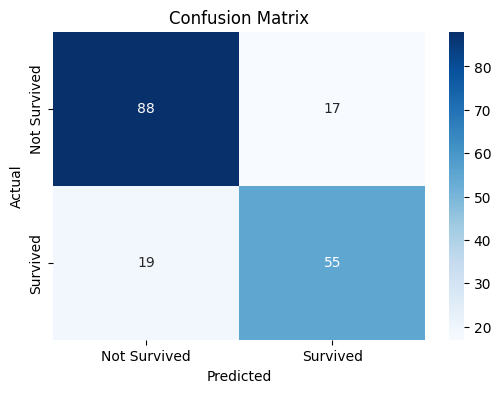

In [53]:
# Plotting Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
